<a href="https://colab.research.google.com/github/ashia-002/Fake-News-Detection-Bilingual-Multimodel/blob/main/AI_Lab01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Extract from zip file and keep it in path

In [2]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/selected_images.zip"
extract_to = "/content/selected_images"

# Create target directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Check files
print("Extracted folders:", os.listdir(extract_to))


Extracted folders: ['real', 'fake']


Root path to work with

In [3]:
root_dir = "/content/selected_images"

categories = {
    "real_bn": os.path.join(root_dir, "real", "bn"),
    "real_en": os.path.join(root_dir, "real", "en"),
    "fake_bn": os.path.join(root_dir, "fake", "bn"),
    "fake_en": os.path.join(root_dir, "fake", "en")
}

### Collect all image path recursively

In [4]:
from tqdm import tqdm

image_paths = []

for cat, path in categories.items():
    for root, _, files in os.walk(path):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, f))

print(f"Total images collected: {len(image_paths)}")


Total images collected: 25414


### Image Preprocessing

In [5]:
import cv2
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import torchvision.transforms as transforms


preprocess_image() handles:

* resize + center crop
* normalization for CNNs/ViTs
* OCR-aware processing (grayscale, CLAHE, adaptive thresholding)

In [6]:
def preprocess_image(img_path, size=224):
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None, None
        h, w = img.shape[:2]
        scale = size / min(h, w)
        resized = cv2.resize(img, (int(w*scale), int(h*scale)))
        cy, cx = resized.shape[0] // 2, resized.shape[1] // 2
        cropped = resized[cy - size//2 : cy + size//2, cx - size//2 : cx + size//2]

        if cropped.shape[0] != size or cropped.shape[1] != size:
            cropped = cv2.resize(cropped, (size, size))

        cnn_img = cropped.astype(np.float32) / 255.0
        cnn_img = (cnn_img - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        cnn_img = np.transpose(cnn_img, (2, 0, 1))  # CHW format

        return cnn_img, None
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None, None


def normalize_for_cnn(img):
    img = img.astype(np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406])[:, None, None]  # shape (3, 1, 1)
    std = np.array([0.229, 0.224, 0.225])[:, None, None]    # shape (3, 1, 1)
    img = (img - mean) / std
    return img


## Image preprocessing by batch of 4000

---



In [7]:
import os
import pickle

# Assuming you already have image_paths list populated
batch_size = 4000
num_batches = (len(image_paths) + batch_size - 1) // batch_size  # ceil division

batches = [image_paths[i*batch_size : (i+1)*batch_size] for i in range(num_batches)]

print(f"Total images: {len(image_paths)}")
print(f"Total batches of size {batch_size}: {num_batches}")

# Save batches to disk
with open("batches.pkl", "wb") as f:
    pickle.dump(batches, f)

print("Saved batches to batches.pkl")


Total images: 25414
Total batches of size 4000: 7
Saved batches to batches.pkl


### Batch 01, 2, 3, 4, 5, 6, 7 Preprocessing

In [8]:
import pickle
import numpy as np
from tqdm import tqdm

# Load batches
with open("batches.pkl", "rb") as f:
    batches = pickle.load(f)

# Choose which batch to process (0-based index)
batch_idx = 0  # change to 1, 2, 3, ... for other batches

batch_paths = batches[batch_idx]

print(f"Processing batch {batch_idx + 1} with {len(batch_paths)} images")

cnn_images = []

for img_path in tqdm(batch_paths, desc=f"Batch {batch_idx+1} preprocessing"):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: couldn't read {img_path}")
        continue

    cnn_img, _ = preprocess_image(img_path)
    if cnn_img is not None:
        cnn_images.append(cnn_img)

image_ids = []
# Convert lists to numpy arrays safely using np.stack (all images should be same shape)
cnn_array = np.stack(cnn_images)

# Save the processed batch
np.save(f"cnn_images_batch_{batch_idx+1}.npy", cnn_array)

# Save image ids (paths) for reference
with open(f"image_ids_batch_{batch_idx+1}.pkl", "wb") as f:
    pickle.dump(image_ids, f)

print(f"Batch {batch_idx + 1} processed and saved.")

Processing batch 1 with 4000 images


Batch 1 preprocessing: 100%|██████████| 4000/4000 [00:55<00:00, 72.02it/s]


Batch 1 processed and saved.


### Normalization by Batch

In [7]:
batch_idx = 1  # Change this to the batch you want to normalize (0–6)
chunk_size = 200

# === FILE PATH ===
batch_file = f"cnn_images_batch_{batch_idx + 1}.npy"

if not os.path.exists(batch_file):
    print(f"File not found: {batch_file}")
else:
    print(f"\nNormalizing batch {batch_idx + 1}: {batch_file}")

    resized_images = np.load(batch_file)
    total_images = resized_images.shape[0]
    img_shape = resized_images.shape[1:]  # (3, 224, 224)

    # Create a memory-mapped file to write normalized output
    memmap_file = np.lib.format.open_memmap(
        batch_file,
        mode='w+',
        dtype=np.float32,
        shape=(total_images, *img_shape)
    )

    # Normalize and write in chunks
    for i in range(0, total_images, chunk_size):
        chunk = resized_images[i:i+chunk_size]
        chunk_norm = np.array([normalize_for_cnn(img) for img in chunk], dtype=np.float32)
        memmap_file[i:i+chunk_norm.shape[0]] = chunk_norm
        print(f"*Processed and saved images {i} to {i + chunk_norm.shape[0] - 1}")

    print(f"Normalized batch {batch_idx + 1} written to {batch_file} Successful")


Normalizing batch 2: cnn_images_batch_2.npy
*Processed and saved images 0 to 199
*Processed and saved images 200 to 399
*Processed and saved images 400 to 599
*Processed and saved images 600 to 799
*Processed and saved images 800 to 999
*Processed and saved images 1000 to 1199
*Processed and saved images 1200 to 1399
*Processed and saved images 1400 to 1599
*Processed and saved images 1600 to 1799
*Processed and saved images 1800 to 1999
*Processed and saved images 2000 to 2199
*Processed and saved images 2200 to 2399
*Processed and saved images 2400 to 2599
*Processed and saved images 2600 to 2799
*Processed and saved images 2800 to 2999
*Processed and saved images 3000 to 3199
*Processed and saved images 3200 to 3399
*Processed and saved images 3400 to 3599
*Processed and saved images 3600 to 3799
*Processed and saved images 3800 to 3999
Normalized batch 2 written to cnn_images_batch_2.npy Successful


### To see normalized image

Loaded batch shape: (4000, 3, 224, 224)


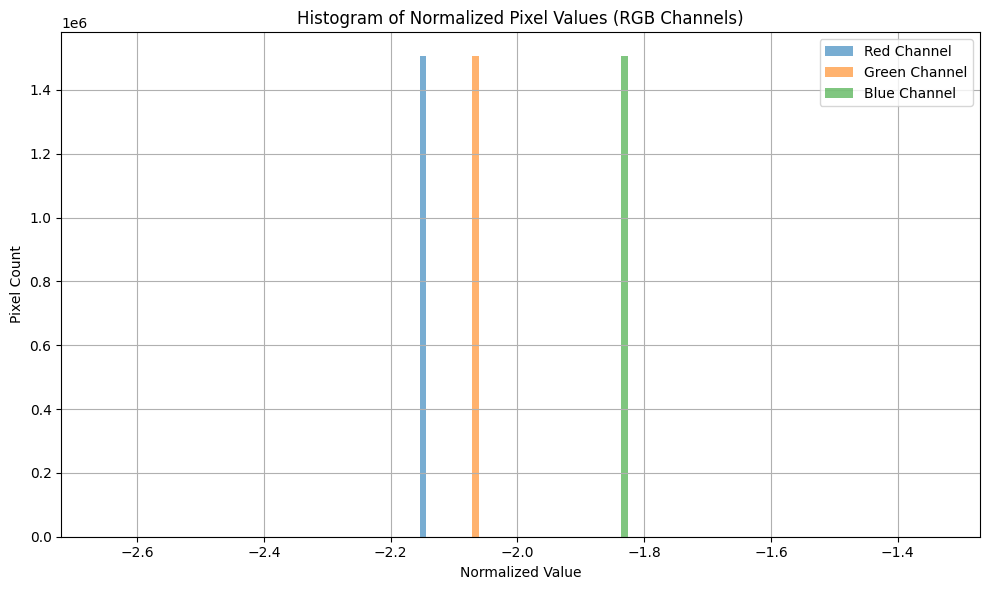

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Load the batch
batch_idx = 0
batch_file = f"cnn_images_batch_{batch_idx+1}.npy"
batch = np.load(batch_file)  # shape: (N, 3, 224, 224)

print(f"Loaded batch shape: {batch.shape}")
sample = batch[:30]

# Plot the range of normalized pixel values for each channel
r_vals = []
g_vals = []
b_vals = []

for img in sample:
    r_vals.extend(img[0].flatten())
    g_vals.extend(img[1].flatten())
    b_vals.extend(img[2].flatten())

plt.figure(figsize=(10, 6))
plt.hist(r_vals, bins=100, alpha=0.6, label='Red Channel')
plt.hist(g_vals, bins=100, alpha=0.6, label='Green Channel')
plt.hist(b_vals, bins=100, alpha=0.6, label='Blue Channel')
plt.title("Histogram of Normalized Pixel Values (RGB Channels)")
plt.xlabel("Normalized Value")
plt.ylabel("Pixel Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Height and Width in resized Batch

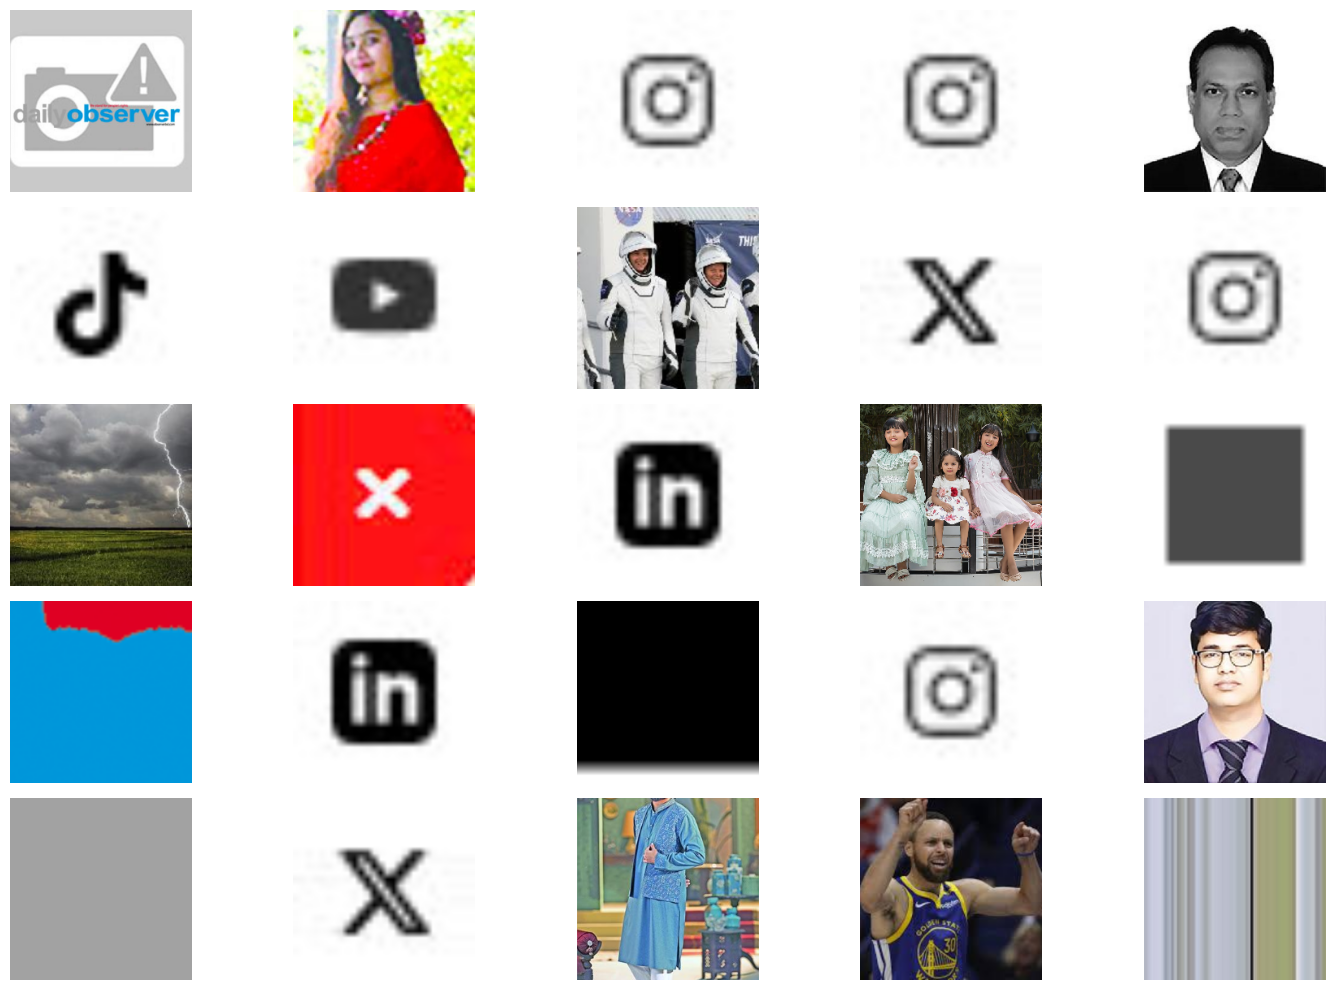

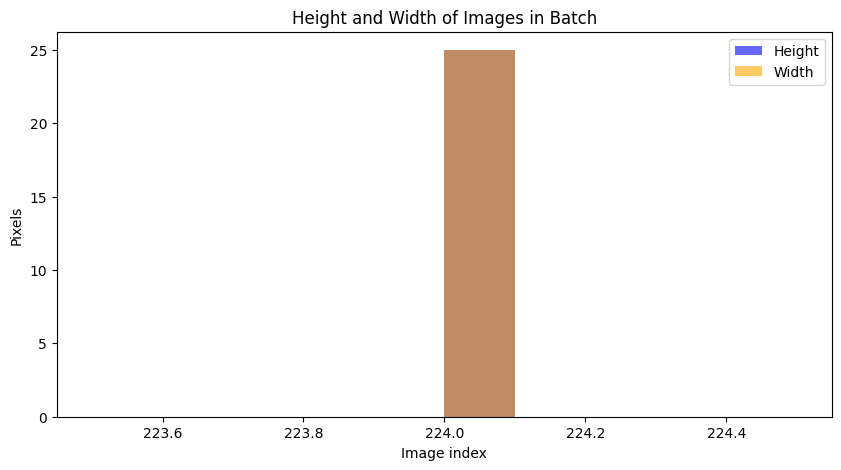

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Load resized and normalized images
batch = np.load("cnn_images_batch_0.npy")  # change as needed

# Define denormalization
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    img = img_tensor * std + mean  # reverse normalization

    # Convert BGR to RGB (because input was BGR in preprocess)
    img = img[[2, 1, 0], :, :]

    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))  # CHW to HWC
    return img

heights = []
widths = []

# Show 25 images and record their sizes
plt.figure(figsize=(15, 10))
for i in range(25):
    img = batch[i]
    img = denormalize(img)
    heights.append(img.shape[0])
    widths.append(img.shape[1])

    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Now plot heights and widths
plt.figure(figsize=(10, 5))
plt.plot(range(25), heights, label='Height')
plt.plot(range(25), widths, label='Width')
plt.xlabel('Image index')
plt.ylabel('Pixels')
plt.title('Height and Width of Images in Batch')
plt.legend()
plt.show()


### load and concatenate all the batches

In [ ]:
# Example to load and combine all batches later:
import numpy as np
import pickle

all_cnn_images = []
all_ocr_images = []
all_image_ids = []

num_batches = 4  # example number of batches you saved

for i in range(1, num_batches+1):
    cnn_batch = np.load(f"cnn_images_batch_{i}.npy")
    ocr_batch = np.load(f"ocr_images_batch_{i}.npy")
    with open(f"image_ids_batch_{i}.pkl", "rb") as f:
        ids_batch = pickle.load(f)

    all_cnn_images.append(cnn_batch)
    all_ocr_images.append(ocr_batch)
    all_image_ids.extend(ids_batch)

all_cnn_images = np.concatenate(all_cnn_images)
all_ocr_images = np.concatenate(all_ocr_images)


### visualize result

In [ ]:
import matplotlib.pyplot as plt

# Visualize CNN vs OCR version
idx = 0
cnn_show = np.transpose(cnn_images[idx], (1, 2, 0))  # CHW → HWC
ocr_show = ocr_images[idx]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cnn_show)
plt.title("CNN Preprocessed Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ocr_show, cmap='gray')
plt.title("OCR Preprocessed Image")
plt.axis('off')
plt.show()
